In [54]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import tqdm
import sys
import numpy as np

if '../src' not in sys.path:
    sys.path.append('../src')

import cv2
from imutils.video import FPS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
imgs = {
    "hbbs": "/home/max/Pictures/hbbs.jpg",
    "max": "/home/max/Pictures/max.png",
    "vid": "/home/max/Pictures/clean.mp4",
}


base_img_size = (256.0, 256.0) # h, w
def scale_img(img, mult=16):
    h, w, _ = img.shape
    h_ratio = base_img_size[0] / h
    w_ratio = base_img_size[1] / w
    ratio = h_ratio if h_ratio < w_ratio else w_ratio
    new_dims =  (int(round(w * ratio)), int(round(h * ratio)))
    new_img = cv2.resize(img,new_dims) #,interpolation=cv2.INTER_CUBIC)    
    h_pad = int(base_img_size[0] - new_dims[0])
    w_pad = int(base_img_size[1] - new_dims[1])
    new_img = np.pad(new_img, ((0,w_pad), (0,h_pad), (0,0)), 'constant')
    return (ratio, new_img)

# def unscale_img(img, orig_ratio, target_hgt, target_wdt):
#     cropped_img = img[0:int(target_hgt * orig_ratio), 0:int(target_wdt * orig_ratio)]
#     big_img = cv2.resize(cropped_img,(target_wdt, target_hgt))
#     plt.imshow(big_img)
    
def load_img(path="/home/max/Pictures/hbbs.jpg"):
    orig_img = cv2.imread(path)
    ratio, img = scale_img(orig_img)
    plt.imshow(img)

    return (ratio, img, orig_img.shape)




In [180]:
from demo import load_model, with_img


In [181]:
model = load_model('../src/hgreg-3d.pth')

1.32642487047 (193, 129, 3)


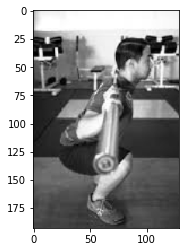

In [182]:
ratio, img, shape = load_img(imgs["hbbs"])
print ratio, shape
plt.imshow(img)
new = unscale_img(img, ratio, shape[0], shape[1])

In [199]:
def with_video(video_path):
    frames = 0
    vs = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    width = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(video_path+"_out.avi",
                                fourcc, vs.get(cv2.CAP_PROP_FPS),
                                (width,
                                height))
    total_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = FPS().start()
    pbar =  tqdm.tqdm_notebook(total = total_frames) 
    print("widht: {} height: {}".format(width, height))
    while True:
        
        ret, frame = vs.read()

        if not ret:
            print("found: {} frames.".format(frames))
            break
        ratio, scaled = scale_img(frame)
        plt.imshow(scaled)
        pred, img = with_img(scaled, model)
        
        if frames == 0:
            print("ratio: {}".format(ratio))
            print(pred)
            cv2.imwrite(video_path + "out.png", scaled)
            return
        pred = pred[0:5, 0:2]
        for idx, (x,y) in enumerate(pred):
            cv2.putText(frame,"{}".format(idx), (int(y),int(x)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 3, cv2.LINE_AA)
            cv2.putText(frame,"{}".format(idx), (int(x/ratio),int(y/ratio)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
            cv2.putText(frame,"{}".format(idx), (int(x/ratio), height - int(y/ratio)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(frame,"{}".format(pred), (0,100),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        out.write(frame)
        frames += 1
        pbar.update(1)
        fps.update()
    fps.stop()
    pbar.close()
    print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
    print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

widht: 720 height: 1280
ratio: 0.2
[[120. 160.]
 [248. 228.]
 [120. 132.]
 [120. 132.]
 [128. 136.]
 [252. 224.]
 [120. 132.]
 [200. 232.]
 [128. 132.]
 [192. 248.]
 [108. 144.]
 [232. 228.]
 [248. 224.]
 [252. 228.]
 [112. 116.]
 [116. 140.]]


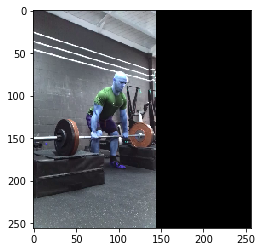

In [200]:
with_video(imgs['vid'])

In [187]:
z = np.zeros((10,10))
z = z[0:4,0:2]
for idx, i in enumerate(z):
    print(idx, i.shape)

(0, (2,))
(1, (2,))
(2, (2,))
(3, (2,))


In [138]:
fps.stop()

In [51]:
fps


<imutils.video.fps.FPS instance at 0x7f45974acf80>

In [53]:
fps.elapsed()

6.854179